In [102]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.tsa.api as tsa
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.seasonal import STL
from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error

from fredapi import Fred

import warnings
from statsmodels.tools.sm_exceptions import ValueWarning
warnings.filterwarnings("ignore", category=ValueWarning)

In [71]:
data = pd.read_csv("/Users/zlatavorobeva/Documents/GitHub/Ruble_Volatility_Prediction2/data/Full_ruble_data.csv")

## 1. Checking stationarity

#### With Classical decomposition

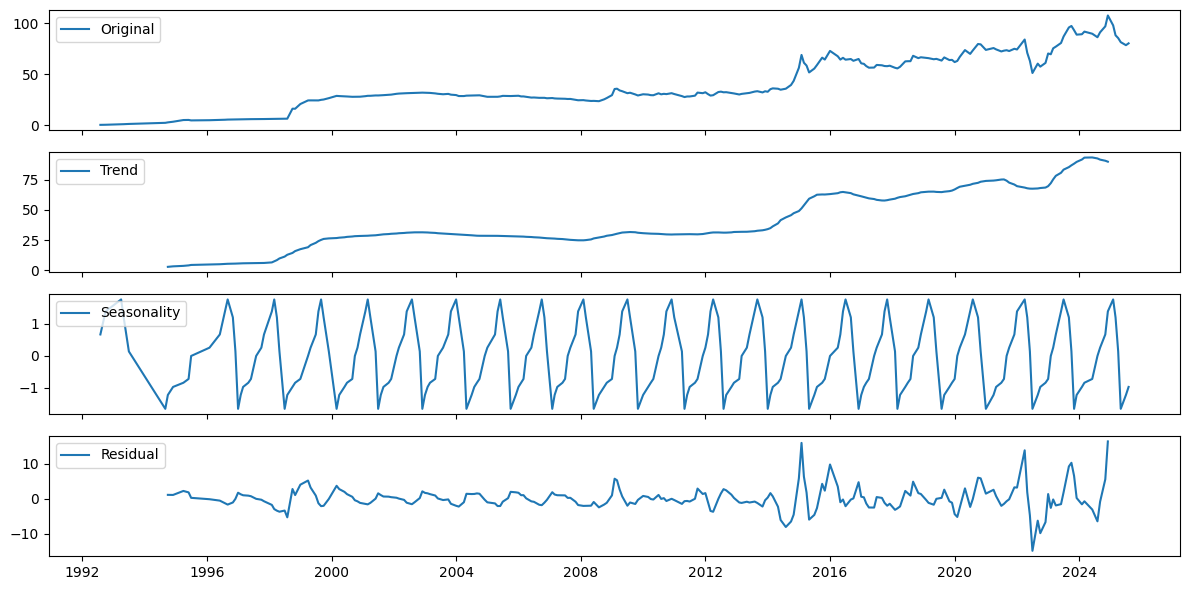

In [72]:
data_decomp = data.copy()
data_decomp['date'] = pd.to_datetime(data_decomp['date'])
data_decomp = data_decomp.sort_values('date')
data_decomp = data_decomp.set_index('date')

# secompose with period=12 (monthly seasonality)
decomposition = seasonal_decompose(rub_series, model='additive', period=12)

fig, axes = plt.subplots(4, 1, figsize=(12, 6), sharex=True)
axes[0].plot(rub_series, label='Original')
axes[0].legend(loc='upper left')

axes[1].plot(decomposition.trend, label='Trend')
axes[1].legend(loc='upper left')

axes[2].plot(decomposition.seasonal, label='Seasonality')
axes[2].legend(loc='upper left')

axes[3].plot(decomposition.resid, label='Residual')
axes[3].legend(loc='upper left')
plt.tight_layout()
plt.show()

#### With Seasonal-Trend decomposition using LOESS (STL) decomposition

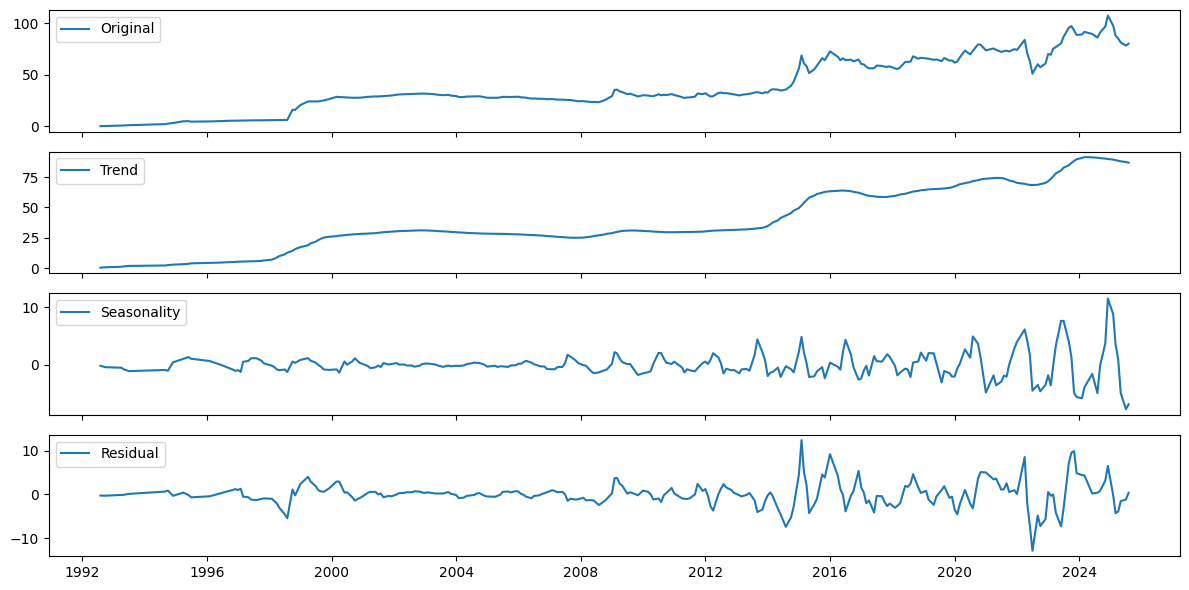

In [73]:
stl = STL(rub_series, period=12) 
result = stl.fit()

trend = result.trend
seasonal = result.seasonal
resid = result.resid


fig, axes = plt.subplots(4, 1, figsize=(12, 6), sharex=True)
axes[0].plot(rub_series, label='Original')
axes[0].legend(loc='upper left')

axes[1].plot(trend, label='Trend')
axes[1].legend(loc='upper left')

axes[2].plot(seasonal, label='Seasonality')
axes[2].legend(loc='upper left')

axes[3].plot(resid, label='Residual')
axes[3].legend(loc='upper left')

plt.tight_layout()
plt.show()

STL offers superior performance for long-term, real-world financial data like exchange rates, especially when structural breaks or non-stationary behavior is present.

In [74]:
data['RUB_diff1'] = data['RUB'].diff()  # First difference (today - yesterday)
data['RUB_diff12'] = data['RUB'].diff(12)  # Seasonal difference (this month - same month last year)

In [75]:
from statsmodels.tsa.stattools import adfuller

adf_result = adfuller(data['RUB_diff1'].dropna())
print(f'ADF Statistic: {adf_result[0]}')
print(f'p-value: {adf_result[1]}')

ADF Statistic: -15.066128585548803
p-value: 8.860286973543265e-28


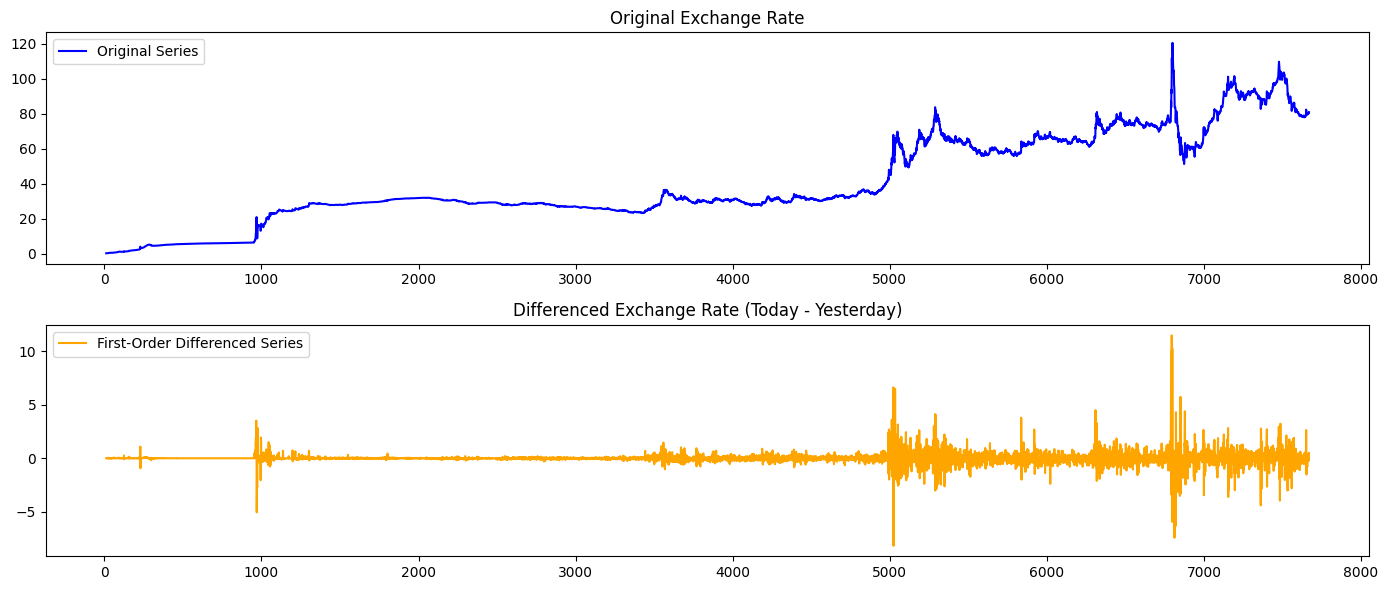

In [76]:
# First-order differencing
data['RUB_diff1'] = data['RUB'].diff()
data = data.dropna()

# Plotting both
plt.figure(figsize=(14, 6))

# Original
plt.subplot(2, 1, 1)
plt.plot(data['RUB'], label='Original Series', color='blue')
plt.title('Original Exchange Rate')
plt.legend()

# Differenced
plt.subplot(2, 1, 2)
plt.plot(data['RUB_diff1'], label='First-Order Differenced Series', color='orange')
plt.title('Differenced Exchange Rate (Today - Yesterday)')
plt.legend()

plt.tight_layout()
plt.show()

In [77]:
result = adfuller(data["RUB"])
print("ADF Statistic:", result[0])
print("p-value:", result[1])
print("Critical Values:", result[4])

ADF Statistic: -1.2960478988593007
p-value: 0.6309784595151413
Critical Values: {'1%': -3.431207789472831, '5%': -2.861919078926616, '10%': -2.5669717792217592}


Since the ADF statistic is higher than all critical values, and the p-value is well above 0.05, we fail to reject the null hypothesis of a unit root. This indicates that the RUB time series is non-stationary.
To proceed with time series modeling, let's apply first-order differencing to induce stationarity.

In [78]:
data["year"].unique()

array([1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002,
       2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013,
       2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024,
       2025])

In [79]:
data_holdout = data.loc[lambda x: x["year"] == 2025, :]
data_work = data.loc[lambda x: x["year"] < 2025, :]

In [80]:
cv_blocks = [
    (1992, 1999, 2000),
    (2000, 2007, 2008),
    (2008, 2015, 2016),
    (2016, 2023, 2024),
]

for fold, (train_start, train_end, test_year) in enumerate(cv_blocks, start=1):
    data_work.loc[:, f"train{fold}"] = (data_work["year"] >= train_start) & (data_work["year"] <= train_end)
    data_work.loc[:, f"test{fold}"] = data_work["year"] == test_year

/var/folders/_x/1_vgy5852g7ctfxwwlkb1ks00000gn/T/ipykernel_82242/1778787088.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_work.loc[:, f"train{fold}"] = (data_work["year"] >= train_start) & (data_work["year"] <= train_end)
/var/folders/_x/1_vgy5852g7ctfxwwlkb1ks00000gn/T/ipykernel_82242/1778787088.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_work.loc[:, f"test{fold}"] = data_work["year"] == test_year
/var/folders/_x/1_vgy5852g7ctfxwwlkb1ks00000gn/T/ipykernel_82242/1778787088.py:9: Set

In [81]:
data_work.loc[:, "holdout"] = data_work["year"] == 2025

/var/folders/_x/1_vgy5852g7ctfxwwlkb1ks00000gn/T/ipykernel_82242/1686548039.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_work.loc[:, "holdout"] = data_work["year"] == 2025


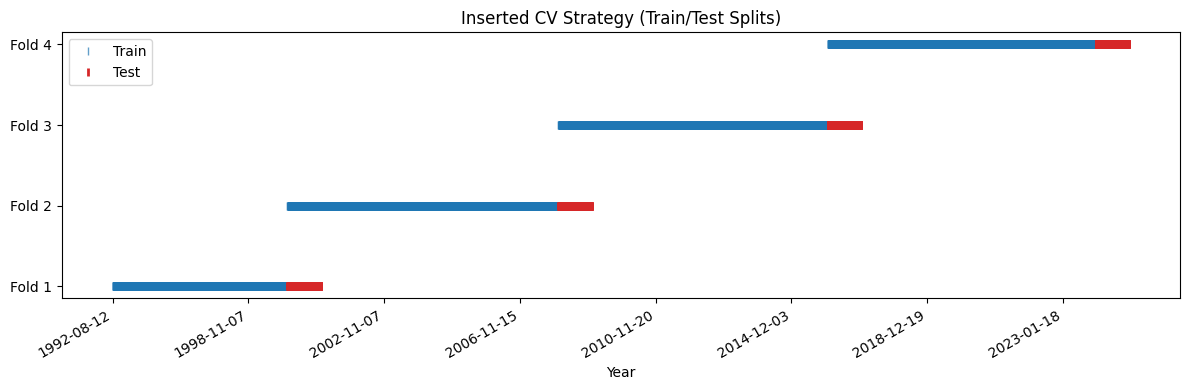

In [82]:
fig, ax = plt.subplots(figsize=(12, 4))

# Plot all 4 folds
for fold in range(1, 5):
    train_mask = data_work[f"train{fold}"]
    test_mask = data_work[f"test{fold}"]

    # Plot train periods
    ax.plot(
        data_work.loc[train_mask, "date"], 
        [fold] * train_mask.sum(), 
        '|', 
        color='tab:blue', 
        label="Train" if fold == 1 else "", 
        alpha=0.7
    )

    # Plot test periods
    ax.plot(
        data_work.loc[test_mask, "date"], 
        [fold] * test_mask.sum(), 
        '|', 
        color='tab:red', 
        label="Test" if fold == 1 else "", 
        markeredgewidth=2
    )

# Formatting
ax.set_yticks(range(1, 5))
ax.set_yticklabels([f"Fold {i}" for i in range(1, 5)])
ax.set_xlabel("Year")
ax.set_title("Inserted CV Strategy (Train/Test Splits)")
ax.legend(loc='upper left')
ax.xaxis.set_major_locator(plt.MaxNLocator(integer=True))
fig.autofmt_xdate()
plt.tight_layout()
plt.show()

In [83]:
# 1. Auto_arima with no intercept (trend='n')
model_auto = auto_arima(
    data_work["RUB"], 
    start_p=0, max_p=5,
    start_q=0, max_q=5,
    d=None,              
    seasonal=False,      
    stepwise=True,       
    trace=True,          
    trend='n'            
)

# 2. Extract best order (p, d, q)
best_order = model_auto.order
print("Best ARIMA order:", best_order)

# 3. Cross-validation with 4 inserted folds
mse_2 = []

for i in range(1, 5):
    # Train/test split
    train_mask = data_work["train" + str(i)]
    test_mask  = data_work["test"  + str(i)]

    y_train = data_work.loc[train_mask, "RUB"].sort_index()
    y_test  = data_work.loc[test_mask,  "RUB"].sort_index()

    # Fit model
    model_3 = ARIMA(endog=y_train, order=best_order, trend='n').fit()

    # Forecast
    phat = model_3.forecast(steps=len(y_test))

    # Compute error
    errsq = (y_test.values - phat.values) ** 2
    mse_2.append(np.mean(errsq))

# 4. Final RMSE across folds
rmse_cv_m2 = float(np.sqrt(np.mean(mse_2)))
print("CV RMSE (Auto ARIMA):", rmse_cv_m2)

# 5. Optional: Ljung-Box test on residuals from last fold
print(acorr_ljungbox(model_3.resid, lags=[10], return_df=True))

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=13419.870, Time=0.09 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=13347.880, Time=0.17 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=13349.945, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=13419.870, Time=0.08 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=13348.161, Time=0.16 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=13335.526, Time=0.36 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=13332.589, Time=0.61 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=13323.588, Time=0.86 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=13324.621, Time=0.29 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=13324.694, Time=0.92 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=13324.222, Time=0.97 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=13325.705, Time=0.78 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=13325.601, Time=0.34 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=13326.164, Time=1.98 sec
 ARIMA(3,1,1)(0,0,0

In [84]:
print(model_3.summary())

                               SARIMAX Results                                
Dep. Variable:                    RUB   No. Observations:                 1973
Model:                 ARIMA(3, 1, 1)   Log Likelihood               -2650.555
Date:                Wed, 17 Sep 2025   AIC                           5311.111
Time:                        15:59:03   BIC                           5339.045
Sample:                             0   HQIC                          5321.375
                               - 1973                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6758      0.044     15.288      0.000       0.589       0.762
ar.L2         -0.0660      0.010     -6.758      0.000      -0.085      -0.047
ar.L3          0.1012      0.007     15.074      0.0

/opt/homebrew/anaconda3/envs/jlab/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/homebrew/anaconda3/envs/jlab/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/opt/homebrew/anaconda3/envs/jlab/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


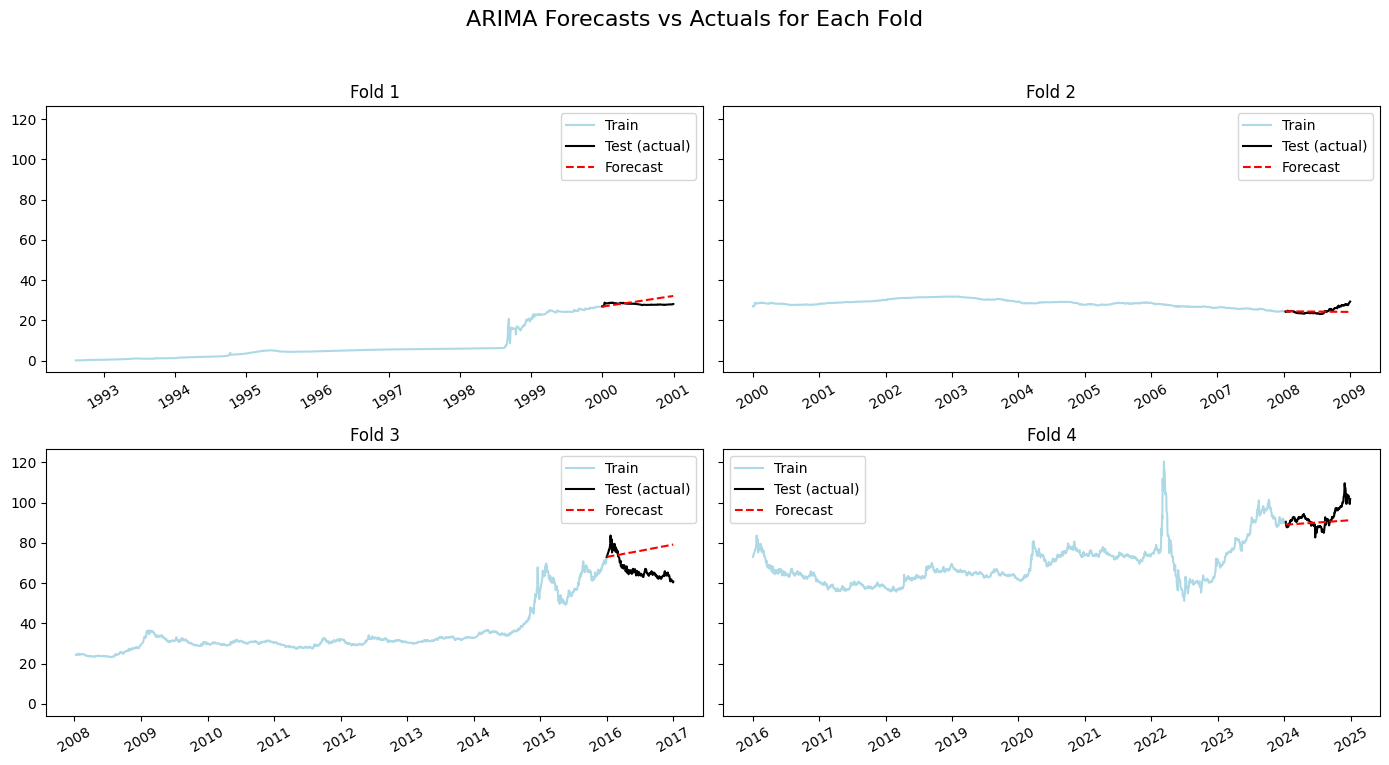

In [87]:
# 3. Cross-validation with 4 inserted folds
mse_2 = []
fig, axs = plt.subplots(2, 2, figsize=(14, 8), sharey=True)
axs = axs.flatten()

for i in range(1, 5):
    # Train/test split
    train_mask = data_work["train" + str(i)]
    test_mask  = data_work["test"  + str(i)]

    y_train = data_work.loc[train_mask, "RUB"].sort_index()
    y_test  = data_work.loc[test_mask,  "RUB"].sort_index()

    # Fit model
    model_3 = ARIMA(endog=y_train, order=best_order, trend='t').fit()

    # Forecast
    phat = model_3.forecast(steps=len(y_test))

    # Compute error
    errsq = (y_test.values - phat.values) ** 2
    mse_2.append(np.mean(errsq))

    # Plotting
    ax = axs[i - 1]
    ax.plot(y_train.index, y_train, label="Train", color="lightblue")
    ax.plot(y_test.index, y_test, label="Test (actual)", color="black")
    ax.plot(y_test.index, phat, label="Forecast", color="red", linestyle="--")

    ax.set_title(f"Fold {i}")
    ax.tick_params(axis='x', rotation=30)
    ax.legend()

plt.suptitle("ARIMA Forecasts vs Actuals for Each Fold", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [89]:
# Fix: Only set index if 'date' column exists, and avoid KeyError if not
if 'date' in data_work.columns:
    data_work['date'] = pd.to_datetime(data_work['date'])
    data_work.set_index('date', inplace=True)

In [90]:
model_3 = auto_arima(
    data_work["RUB"], 
    start_p=0, max_p=5,
    start_q=0, max_q=5,
    d=None,  
    m=12,            # Let it choose d
    seasonal=True,      
    stepwise=True,
    trace=True,
    trend=None           # Let it choose (drift if needed)
)

# 2. Extract best order
best_order = model_3.order
print("Best ARIMA order:", best_order)

# 3. Cross-validation across 4 folds
mse_2 = []

for i in range(1, 5):
    train_mask = data_work[f"train{i}"]
    test_mask  = data_work[f"test{i}"]

    y_train = data_work.loc[train_mask, "RUB"].sort_index()
    y_test  = data_work.loc[test_mask,  "RUB"].sort_index()

    # Use trend='t' (linear trend) which works with d > 0
    model = ARIMA(endog=y_train, order=best_order, trend='t').fit()

    # Forecast as many steps as test set
    phat = model.forecast(steps=len(y_test))

    # Squared errors
    errsq = (y_test.values - phat.values) ** 2
    mse_2.append(np.mean(errsq))

# 4. Final RMSE across folds
rmse_cv = float(np.sqrt(np.mean(mse_2)))
print("CV RMSE (ARIMA w/ linear trend):", rmse_cv)

# 5. Optional: Check residual autocorrelation for the last fold
print(acorr_ljungbox(model.resid, lags=[10], return_df=True))

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=13418.393, Time=3.32 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=13417.951, Time=0.24 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=13345.006, Time=1.91 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=13347.242, Time=2.16 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=13419.870, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=13346.659, Time=0.28 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=13346.945, Time=4.94 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=13346.969, Time=3.81 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=13345.029, Time=1.44 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=13348.970, Time=7.52 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=13416.555, Time=1.19 sec
 ARIMA(2,1,0)(1,0,0)[12] intercept   : AIC=13344.995, Time=1.99 sec
 ARIMA(2,1,0)(0,0,0)[12] intercept   : AIC=13347.032, Time=0.42 sec
 ARIMA(2,1,0)(2,0,0)[12] intercept   : AIC=13346.966, Time=6.62 sec
 ARIM

/opt/homebrew/anaconda3/envs/jlab/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/homebrew/anaconda3/envs/jlab/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/opt/homebrew/anaconda3/envs/jlab/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


CV RMSE (ARIMA w/ linear trend): 6.409927244367966
      lb_stat  lb_pvalue
10  11.737628      0.303


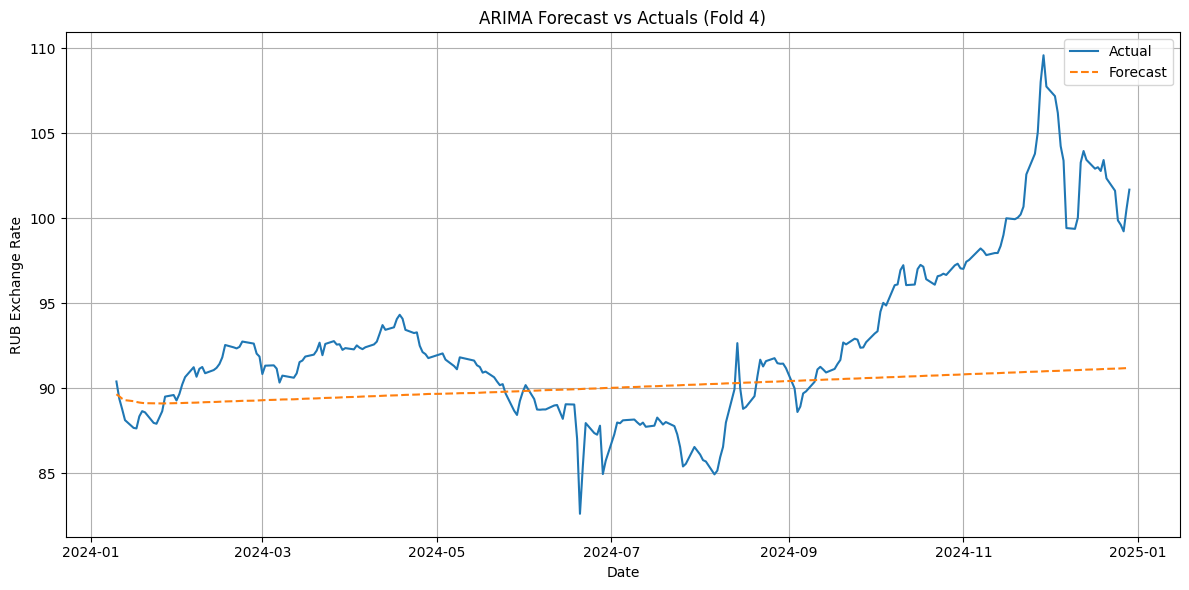

In [95]:
import matplotlib.pyplot as plt

# Get the test and predicted values for the last fold (fold 4)
last_test_mask = data_work["test4"]
y_test = data_work.loc[last_test_mask, "RUB"].sort_index()

# Refit the model on the corresponding training data for fold 4
last_train_mask = data_work["train4"]
y_train = data_work.loc[last_train_mask, "RUB"].sort_index()
model_last = ARIMA(endog=y_train, order=best_order, trend='t').fit()

# Forecast
phat = model_last.forecast(steps=len(y_test))

# Plot actual vs forecast
plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test, label='Actual')
plt.plot(y_test.index, phat, label='Forecast', linestyle='--')
plt.title("ARIMA Forecast vs Actuals (Fold 4)")
plt.xlabel("Date")
plt.ylabel("RUB Exchange Rate")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [97]:
def first_difference(data):
    data_diff = data.diff().dropna()
    return data_diff

In [129]:
data["GDP_per_capita"]

12       3098.802734
13       3098.802734
14       3098.802734
15       3098.802734
16       3098.802734
            ...     
7665    14260.000000
7666    14260.000000
7667    14260.000000
7668    14260.000000
7669    14260.000000
Name: GDP_per_capita, Length: 7658, dtype: float64

In [127]:
GDP_diff = first_difference(data["GDP_per_capita"])
GDP_diff

13      0.0
14      0.0
15      0.0
16      0.0
17      0.0
       ... 
7665    0.0
7666    0.0
7667    0.0
7668    0.0
7669    0.0
Name: GDP_per_capita, Length: 7657, dtype: float64

In [121]:
def acf_pacf_plots(data, title):
    fig, axes = plt.subplots(2, 1, figsize=(8, 6))  # 2 rows, 1 column
    plot_acf(data, ax=axes[0], lags=20)
    axes[0].set_title(f"ACF - {title}")
    
    plot_pacf(data, ax=axes[1], lags=20, method='ywm')  # method can be changed to 'ols' if needed
    axes[1].set_title(f"PACF - {title}")
    
    plt.tight_layout()
    plt.show()

In [124]:
data

,currency_rate,date,year,quarter,month,day,dow,weekend,currency_rate_change,denomination,RUB,GDP_per_capita,Brent_price,GDP_deflator,FD_investment,Inflation,RUB_diff1,RUB_diff12
12,161.7000,1992-08-12,1992,3,8,12,3,False,0.123839,pre,0.1617,3098.802734,19.65,1490.418425,1.161000e+09,1490.418425,0.0002,0.03644
13,162.5000,1992-08-14,1992,3,8,14,5,False,0.494743,pre,0.1625,3098.802734,19.65,1490.418425,1.161000e+09,1490.418425,0.0008,0.02770
14,162.5000,1992-08-19,1992,3,8,19,3,False,0.000000,pre,0.1625,3098.802734,19.65,1490.418425,1.161000e+09,1490.418425,0.0000,0.03200
15,162.6000,1992-08-21,1992,3,8,21,5,False,0.061538,pre,0.1626,3098.802734,19.65,1490.418425,1.161000e+09,1490.418425,0.0001,0.03230
16,168.1000,1992-08-26,1992,3,8,26,3,False,3.382534,pre,0.1681,3098.802734,19.65,1490.418425,1.161000e+09,1490.418425,0.0055,0.03790
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7665,80.4256,2025-08-18,2025,3,8,18,1,False,0.503859,post,80.4256,14260.000000,67.83,8.200000,3.300000e+09,8.140000,0.4032,0.10930
7666,80.3466,2025-08-19,2025,3,8,19,2,False,-0.098227,post,80.3466,14260.000000,67.83,8.200000,3.300000e+09,8.140000,-0.0790,0.01770
7667,80.1045,2025-08-20,2025,3,8,20,3,False,-0.301320,post,80.1045,14260.000000,67.83,8.200000,3.300000e+09,8.140000,-0.2421,0.43090
7668,80.2548,2025-08-21,2025,3,8,21,4,False,0.187630,post,80.2548,14260.000000,67.83,8.200000,3.300000e+09,8.140000,0.1503,0.20580


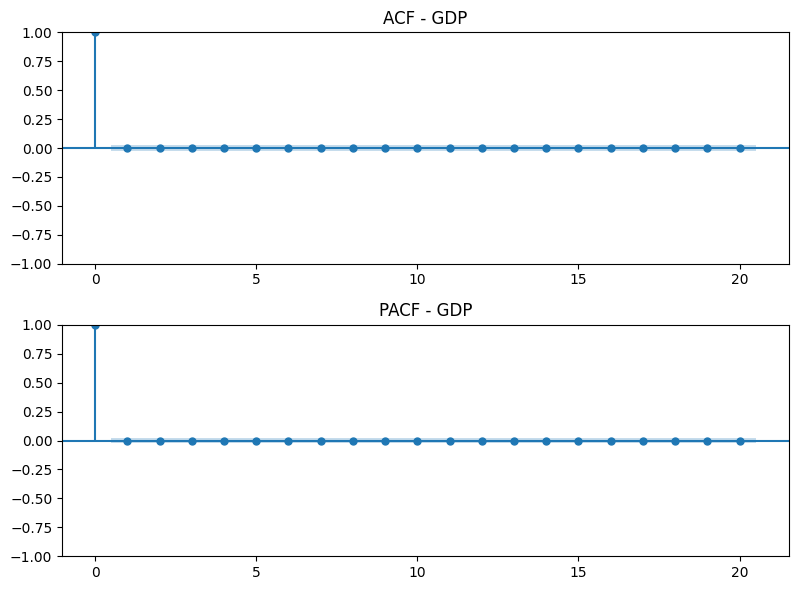

In [122]:
acf_pacf_plots(GDP_diff, "GDP")
